# Advanced Regression

In this week's tutorial, we will be working through some examples of how we can use regression methods to understand the relationship between some predictors and a response variable.

This week we will again be working with Python, using **Pandas**, **scikit-learn**, and [**statsmodels**](https://www.statsmodels.org/stable/index.html). **statsmodel** is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. It provides a nice summary function for linear regression.

This workshop will cover the use of **linear regression**, **stepwise regression**, **Lasso**, **regression tree**, and **random forest regressor**. This sounds like a lot in one workshop, but you'll begin to get a sense of how they differ after comparing the results.

Let's first import the basic libraries we will need. `Pandas` for data import and handling, `matplotlib` for graphing non-Pandas arrays, and `Numpy` for maths tools. **Run the script below to get started.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

### Data Interrogation

The dataset you will use relates to daily counts of rented bicycles from the bicycle rental company Capital-Bikeshare in Washington D.C, along with weather and seasonal information. The goal here is to predict how many bikes will be rented depending on the weather and the day. The original data can be downloaded from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

The dataset used in this workshop has been slightly processed by Christoph Molnar. You can find the processing R-script in his [Github repository](https://github.com/christophM/interpretable-ml-book/blob/master/R/get-bike-sharing-dataset.R). Here, the dataset is provided as a csv file on Moodle.


In [44]:
#reading the cleaned file
trees_in_Camden = pd.read_csv('cleaned.csv')

In [47]:
trees_in_Camden.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19919 entries, 0 to 19918
Data columns (total 24 columns):
Unnamed: 0              19919 non-null int64
id                      19919 non-null int64
No_Trees                19919 non-null int64
Site_Name               19919 non-null object
Sci_Name                19919 non-null object
Com_Name                19919 non-null object
Date                    19919 non-null object
Height_M                19919 non-null float64
Spread_M                19919 non-null float64
Diameter_CM             19919 non-null float64
Maturity                19919 non-null object
Condition               19919 non-null object
Removed_Soon            19919 non-null bool
Newly_Planted           19919 non-null bool
Amenity_Value           19919 non-null float64
Carbon_StorageKG        19919 non-null float64
Carbon_Sequest_YR       19919 non-null float64
Pollution_Year_grams    19919 non-null float64
Ward_Code               19919 non-null object
Ward_Name        

In [43]:
#drop columns/variables such as id,number of trees,site name etc..
trees_in_Camden.head()
trees_in_Camden_Cleaned=trees_in_Camden.drop(['Unnamed: 0','id','No_Trees','Site_Name','Sci_Name','Com_Name','Date','Removed_Soon','Newly_Planted','Ward_Code','Ward_Name','Lon','Lat','Loc','Loc','Uploaded'],axis = 1)
trees_in_Camden_Cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19919 entries, 0 to 19918
Data columns (total 9 columns):
Height_M                19919 non-null float64
Spread_M                19919 non-null float64
Diameter_CM             19919 non-null float64
Maturity                19919 non-null object
Condition               19919 non-null object
Amenity_Value           19919 non-null float64
Carbon_StorageKG        19919 non-null float64
Carbon_Sequest_YR       19919 non-null float64
Pollution_Year_grams    19919 non-null float64
dtypes: float64(7), object(2)
memory usage: 1.4+ MB


There are two data types: categorical (aka `object`), and numerical (including `int64` and `float64`). 

Before undertaking regression, several steps should be done, which include:
- Converting categorical variables into dummy variables
- Dealing with multicollinearity (and removing some variables if necessary)

### Converting categorical variables
First, we need to convert categorical variables into dummy/indicator variables, using `One-Hot Encoding`.

In [18]:
trees_in_Camden_numeric = pd.get_dummies(trees_in_Camden_Cleaned)

In [19]:
# check out the new dataFrame
trees_in_Camden_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19919 entries, 0 to 19918
Data columns (total 16 columns):
Height_M                19919 non-null float64
Spread_M                19919 non-null float64
Diameter_CM             19919 non-null float64
Amenity_Value           19919 non-null float64
Carbon_StorageKG        19919 non-null float64
Carbon_Sequest_YR       19919 non-null float64
Pollution_Year_grams    19919 non-null float64
Maturity_Juvenile       19919 non-null uint8
Maturity_Mature         19919 non-null uint8
Maturity_Middle aged    19919 non-null uint8
Maturity_Over Mature    19919 non-null uint8
Maturity_Veteran        19919 non-null uint8
Condition_Excellent     19919 non-null uint8
Condition_Fair          19919 non-null uint8
Condition_Good          19919 non-null uint8
Condition_Poor          19919 non-null uint8
dtypes: float64(7), uint8(9)
memory usage: 1.2 MB


Remember that, a cateogircal variable of K categories or levels, usually enters a regression as a sequence of K-1 dummy variables. The level that is left out becomes the reference level, and this is important for interpreting the regression model.

Here we manually choose the reference level for each categorical variable and exclude them from the DataFrame. You can change the reference levels if you want.

In [20]:
trees_in_Camden_final = trees_in_Camden_numeric.drop(['Maturity_Juvenile', 'Condition_Excellent'], axis=1)

# double check the result
trees_in_Camden_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19919 entries, 0 to 19918
Data columns (total 14 columns):
Height_M                19919 non-null float64
Spread_M                19919 non-null float64
Diameter_CM             19919 non-null float64
Amenity_Value           19919 non-null float64
Carbon_StorageKG        19919 non-null float64
Carbon_Sequest_YR       19919 non-null float64
Pollution_Year_grams    19919 non-null float64
Maturity_Mature         19919 non-null uint8
Maturity_Middle aged    19919 non-null uint8
Maturity_Over Mature    19919 non-null uint8
Maturity_Veteran        19919 non-null uint8
Condition_Fair          19919 non-null uint8
Condition_Good          19919 non-null uint8
Condition_Poor          19919 non-null uint8
dtypes: float64(7), uint8(7)
memory usage: 1.2 MB


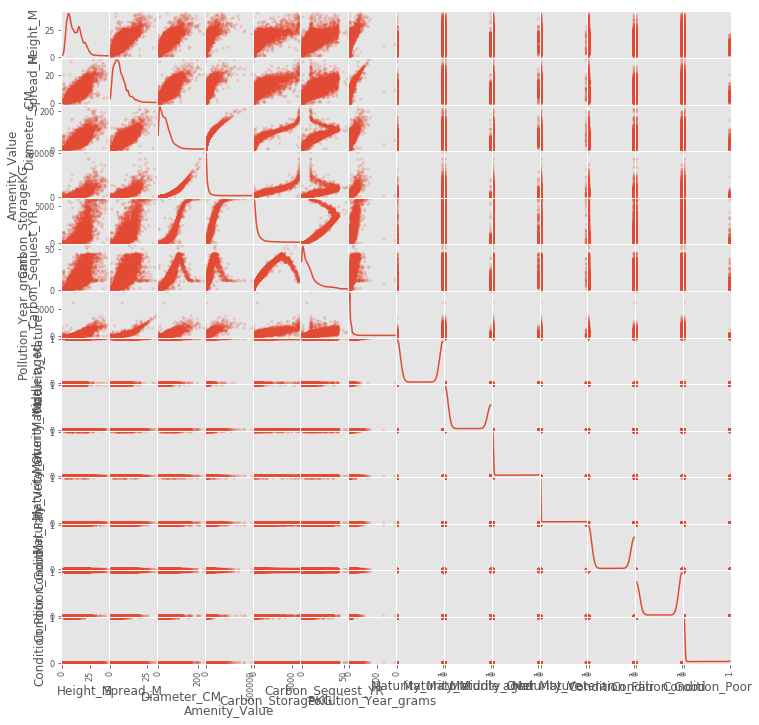

In [42]:
# takes the dataset, an alpha value for opacity, a figure size setting, and a specification of the diagonal charts
output = pd.plotting.scatter_matrix(trees_in_Camden_final, alpha=0.2, figsize=(12, 12), diagonal='kde')

### Dealing with multicollinearity

In regression, `colinearity` is the problem when **two** variables are highly correlated and therefore contain similar information about the variance within the dataset. Colinearity among variables can be detected by creating a correlation matrix.

On the other hand, `multicolinearity` emerges when three or more variables, which are highly correlated, are included in a model. It can emerge even when each pair of variables involved are not colinear. For example, think of the four dummy variables relating to seasons in the `bike_rental_numeric` dataset.  

You can check the colinearity between attributes using a correlation matrix as below. Think of these two questions:

- **What can you say about this plot? For example, which pair of variables are highly correlated, and can you explain it?**
- **Can you use the correlation matrix to deal with multicolinearity, for example, by removing one of the two variables if their correlation is above 0.75?** (Hint: a short answer is NO)

Text(0.5, 1.05, 'Correlation Matrix')

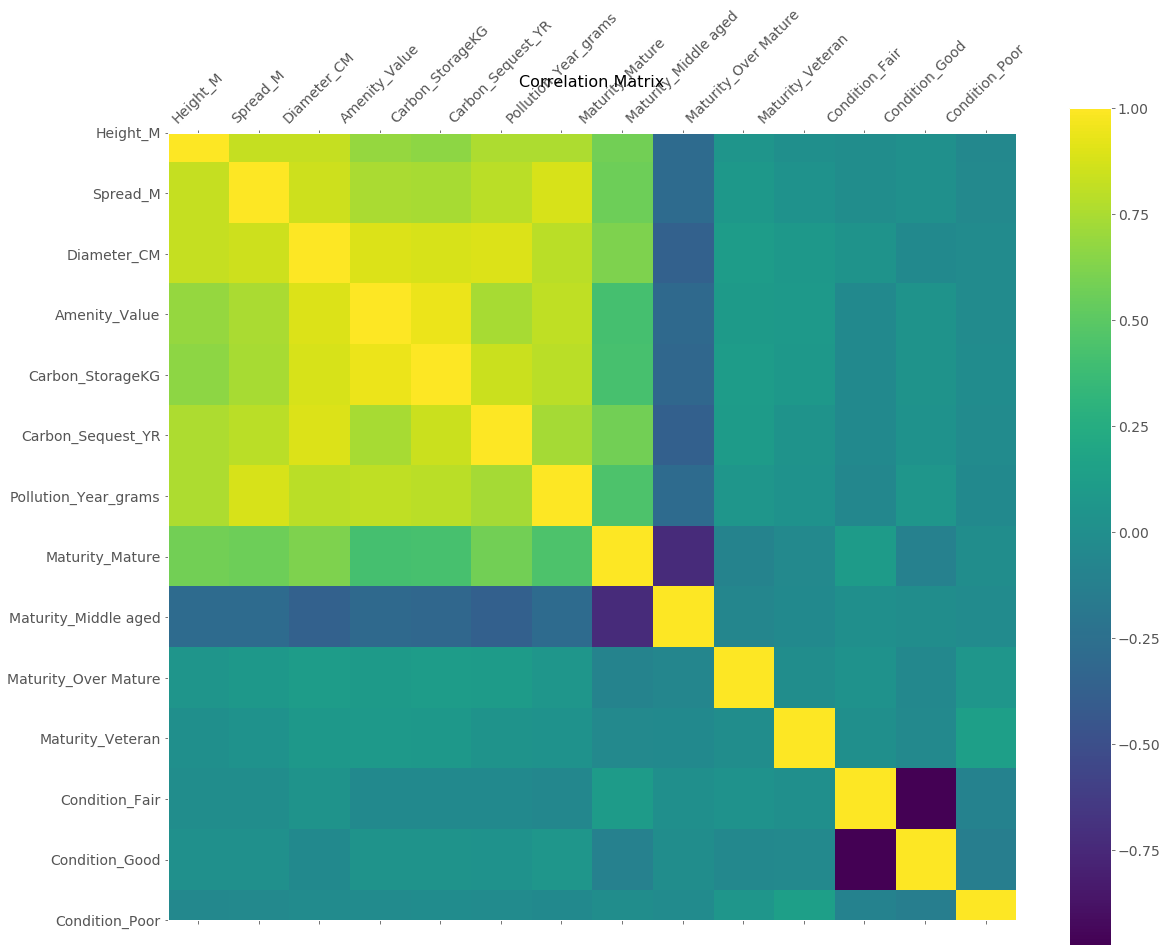

In [21]:
df = trees_in_Camden_final
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

There are several ways to deal with multicolinearity in linear regression, including **stepwise regression**, **VIF**, and **Lasso**.

#### Stepwise regression

In [22]:
# This code comes from the module of Quantitative Methods (CASA0007), and is prepared by Dr Thomas Evans

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [23]:
# split the DataFrame into predictors and response
predictors_trees_in_Camden_final = trees_in_Camden_final.drop(columns=['Pollution_Year_grams'], axis=1)
response_trees_in_Camden_final = trees_in_Camden_final[['Pollution_Year_grams']]

In [24]:
# use stepwise regression on the bike_rental dataset
list_predictor_select_stepwise = stepwise_selection(X=predictors_trees_in_Camden_final, y=response_trees_in_Camden_final)
print("The predictors that are selected by stepwise regression are:")
print(list_predictor_select_stepwise)

C:\Users\SaraMoatti\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\SaraMoatti\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\SaraMoatti\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\SaraMoatti\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\SaraMoatti\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWa

Add  Carbon_StorageKG               with p-value 0.0
Add  Amenity_Value                  with p-value 0.0
Add  Carbon_Sequest_YR              with p-value 0.0
Add  Height_M                       with p-value 0.0
Drop Carbon_Sequest_YR              with p-value 0.136881
Add  Spread_M                       with p-value 0.0
Drop Height_M                       with p-value 0.186614
Add  Diameter_CM                    with p-value 0.0

C:\Users\SaraMoatti\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.



Add  Height_M                       with p-value 9.02334e-157
Add  Maturity_Middle aged           with p-value 1.02277e-22
Add  Maturity_Mature                with p-value 4.16145e-33
Add  Maturity_Over Mature           with p-value 9.68436e-19
Add  Maturity_Veteran               with p-value 7.56167e-09
The predictors that are selected by stepwise regression are:
['Carbon_StorageKG', 'Amenity_Value', 'Spread_M', 'Diameter_CM', 'Height_M', 'Maturity_Middle aged', 'Maturity_Mature', 'Maturity_Over Mature', 'Maturity_Veteran']


#### VIF

The `Variance Inflation Factor` (VIF) is a measure of multicolinearity among predictors within a multiple regression task. It is the quotient of the variance in a model with multiple predictors by the variance of a model with a single predictor. More explanation of the theory can be found [here](https://en.wikipedia.org/wiki/Variance_inflation_factor). 

Steps for using VIF to deal with multicolineartiy are:

- Make a list of predictors, and loop over this list.
- For each predictor, compute its VIF using the steps
 - run a multiple regression using this predictor as the response against all the other predictors
 - Calculate the VIF for this predictor
 - If the VIF > 10, then multicolinearity is high. A cutoff of 5 is also commonly used. Remove this predictor.
- Move to the next predictor in the list, until all predictors are tested.

Below is an example of using VIF on the `bike_rental` dataset. Note that the `statsmodels` package is used.

In [25]:
# calculating VIF
# This function is from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def calculate_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with features removed
    '''
    const = add_constant(df)
    cols = const.columns
    variables = np.arange(const.shape[1])
    vif_df = pd.Series([variance_inflation_factor(const.values, i) 
               for i in range(const.shape[1])], 
              index=const.columns).to_frame()

    vif_df = vif_df.sort_values(by=0, ascending=False).rename(columns={0: 'VIF'})
    vif_df = vif_df.drop('const')
    vif_df = vif_df[vif_df['VIF'] > thresh]

    print('Features above VIF threshold:\n')
    print(vif_df[vif_df['VIF'] > thresh])

    col_to_drop = list(vif_df.index)

    for i in col_to_drop:
        print('Dropping: {}'.format(i))
        df = df.drop(columns=i)

    return df

In [26]:
# using VIF on the bike_rental dataset
df_predictors_select_VIF = calculate_vif_(predictors_trees_in_Camden_final)
print("The columns remaining after VIF selection are:")
print(df_predictors_select_VIF.columns)

Features above VIF threshold:

                                                       VIF
Condition_Good                                    613.3416
Condition_Fair                                    608.9401
Condition_Poor                                     33.8566
Diameter_CM                                        23.8761
Amenity_Value                                      19.4206
Carbon_StorageKG                                   16.5272
Carbon_Sequest_YR                                  10.5350
Maturity_Mature                                     5.2699
Dropping: Condition_Good
Dropping: Condition_Fair
Dropping: Condition_Poor
Dropping: Diameter_CM
Dropping: Amenity_Value
Dropping: Carbon_StorageKG
Dropping: Carbon_Sequest_YR
Dropping: Maturity_Mature
The columns remaining after VIF selection are:
Index(['Height_M', 'Spread_M', 'Maturity_Middle aged', 'Maturity_Over Mature',
       'Maturity_Veteran'],
      dtype='object')


## Linear regression

Now we can fit a linear regression model after dealing with the multicolinearity, and we will do it using the sklearn package. 

Just like clustering analysis in `sklearn`, we will run the regression model using the `.fit()` function. Make sure you get the variables the right way around.

In [28]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X=df_predictors_select_VIF, y=response_trees_in_Camden_final)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now that we've created our fit, it's time to look at the structure of the model and how well it fits the data.

There are a number of ways to do this. In the first instance, as with any linear regression model, we want to get a grip on the coefficients and intercept of the model. Helpfully, these two functions are built into the LinearRegression object. **Consult the documentation and see if you can find out how to extract these.**

In [29]:
print(lr.intercept_)
df_coef_lr_VIF = pd.DataFrame({"var": df_predictors_select_VIF.columns.values, "coef":lr.coef_[0]})
print(df_coef_lr_VIF)

[-208.11008859]
                    var                                     coef
0              Height_M                                   3.6776
1              Spread_M                                  61.6283
2  Maturity_Middle aged                                 -20.5554
3  Maturity_Over Mature                                 -18.3393
4      Maturity_Veteran                                  20.9950


The code below will generate the R2 score for us. Run the code and see how well the model performed.

In [31]:
lr.score(X=df_predictors_select_VIF, y=response_trees_in_Camden_final)

0.7833017281250373

It is quite difficult to get a good summary of the regression model using `sklearn` package. You can try it.

An alternative is to use the `statsmodel` package, which comes with a nice **summary()** function.

In [32]:
# fit a lineare regression model using statsmodel
regressor_OLS = sm.OLS(endog=response_trees_in_Camden_final, exog=sm.add_constant(df_predictors_select_VIF)).fit()
regressor_OLS.summary()

C:\Users\SaraMoatti\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Pollution_Year_grams   R-squared:                       0.783
Model:                              OLS   Adj. R-squared:                  0.783
Method:                   Least Squares   F-statistic:                 1.440e+04
Date:                  Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                          12:13:20   Log-Likelihood:            -1.2728e+05
No. Observations:                 19919   AIC:                         2.546e+05
Df Residuals:                     19913   BIC:                         2.546e+05
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -208.1101      2.504    -83.097      0.000    -213.019    -203.201
Height_M                 3.6776      0.298     12.349      0.000       3.094       4.261
Spread_M                61.6283      0.449    137.355      0.000      60.749      62.508
Maturity_Middle aged   -20.5554      2.238     -9.183      0.000     -24.943     -16.168
Maturity_Over Mature   -18.3393     10.907     -1.681      0.093     -39.718       3.040
Maturity_Veteran        20.9950     22.583      0.930      0.353     -23.270      65.260
==============================================================================
Omnibus:                    37525.619   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        298957440.945
Skew:                          13.762   Prob(JB):                         0.00
Kurtosis:                     602.542   Cond. No.                         324.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that the R2 value of 0.783 is good, meaning that only 78.3% of the variance in y can be explained by the predictors used.
